In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform
import matplotlib.pyplot as plt
from invertiblewavelets import Cauchy
from scipy import signal

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [2]:
data = np.load("data.npy")

# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array
data +=100 * signal.square(2 * np.pi * 1 * t) + 100 *np.sin(2 * np.pi * 6.25 * t) 

#### Create Transform Object and Analysis Filters

In [3]:
# Initializing the Transform object automatically forms the analysis and synthesis filter bank during __init__
transform = Transform(
    data=data,
    fs = sample_rate,
    wavelet=Cauchy(),
    pad_method='symmetric', # Padding method for the convolution calls np.pad. Set to None if no padding
)

#### Transform and Inverse the Data

Reconstruction error: 4.048657513876378e-08


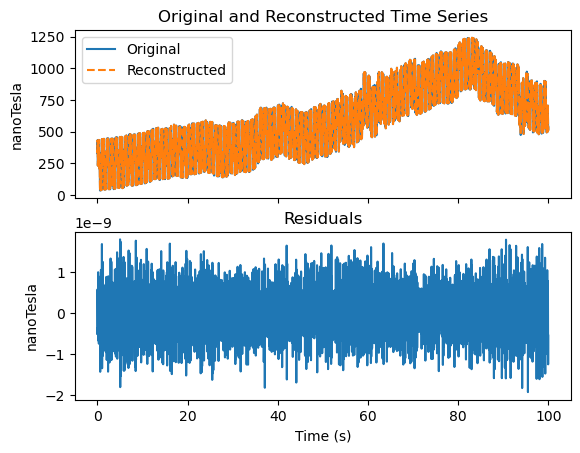

In [4]:
# Perform forward wavelet transform
coefficients = transform.forward(data)

# Perform inverse wavelet transform (reconstruction)
reconstructed = transform.inverse(coefficients)

# Calculate and print reconstruction error
reconstruction_error = np.linalg.norm(reconstructed - data)
print(f"Reconstruction error: {reconstruction_error}")

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(t, data, label='Original')
ax[0].plot(t, reconstructed, label='Reconstructed', linestyle='--')    
ax[0].set_ylabel('nanoTesla')
ax[0].legend()
ax[0].set_title('Original and Reconstructed Time Series')
ax[1].plot(t, data - reconstructed)
ax[1].set_title('Residuals')
ax[1].set_ylabel('nanoTesla')
ax[1].set_xlabel('Time (s)')
plt.show()

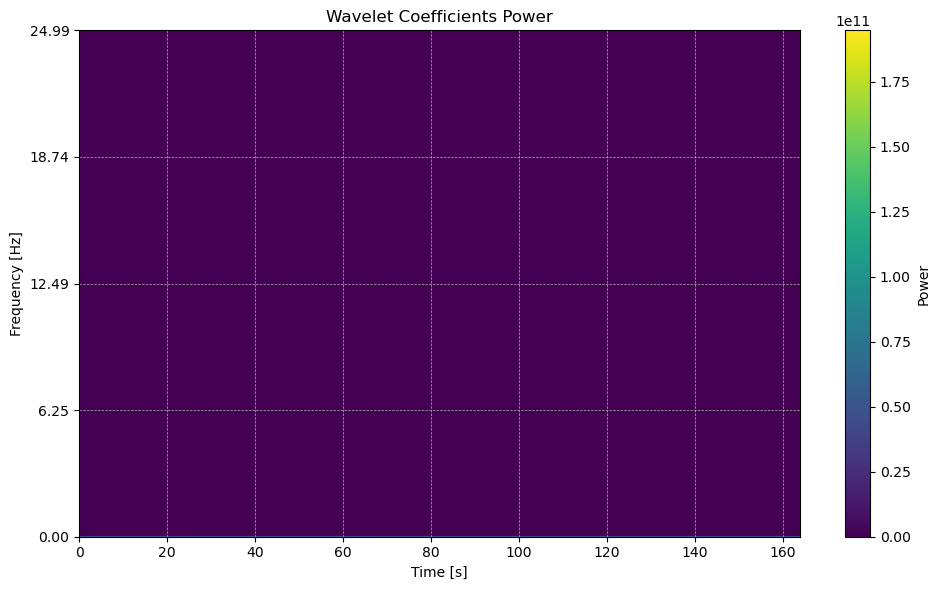

In [5]:
transform.power_scalogram(coefficients)